In [29]:
import matplotlib.pyplot as plt
import pathlib, os, random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras


from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout , GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint

In [30]:
train_path="../input/bird200v1/train/"
no_birds_classes = os.listdir(train_path)
len(no_birds_classes)

200

In [31]:
data_dir = pathlib.Path("../input/bird200v1/train")
BirdClasses = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(BirdClasses)

['001.Black_footed_Albatross' '002.Laysan_Albatross' '003.Sooty_Albatross'
 '004.Groove_billed_Ani' '005.Crested_Auklet' '006.Least_Auklet'
 '007.Parakeet_Auklet' '008.Rhinoceros_Auklet' '009.Brewer_Blackbird'
 '010.Red_winged_Blackbird' '011.Rusty_Blackbird'
 '012.Yellow_headed_Blackbird' '013.Bobolink' '014.Indigo_Bunting'
 '015.Lazuli_Bunting' '016.Painted_Bunting' '017.Cardinal'
 '018.Spotted_Catbird' '019.Gray_Catbird' '020.Yellow_breasted_Chat'
 '021.Eastern_Towhee' '022.Chuck_will_Widow' '023.Brandt_Cormorant'
 '024.Red_faced_Cormorant' '025.Pelagic_Cormorant' '026.Bronzed_Cowbird'
 '027.Shiny_Cowbird' '028.Brown_Creeper' '029.American_Crow'
 '030.Fish_Crow' '031.Black_billed_Cuckoo' '032.Mangrove_Cuckoo'
 '033.Yellow_billed_Cuckoo' '034.Gray_crowned_Rosy_Finch'
 '035.Purple_Finch' '036.Northern_Flicker' '037.Acadian_Flycatcher'
 '038.Great_Crested_Flycatcher' '039.Least_Flycatcher'
 '040.Olive_sided_Flycatcher' '041.Scissor_tailed_Flycatcher'
 '042.Vermilion_Flycatcher' '043.Ye

In [32]:
def view_random_image(target_dir, target_class):
  
  # setting up the image directory
  target_folder = target_dir + target_class

  #get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  #read image and plotting it
  img = plt.imread(target_folder + "/" + random_image[0] )
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  #print(f"Image shape: {img.shape}")
  
  return img

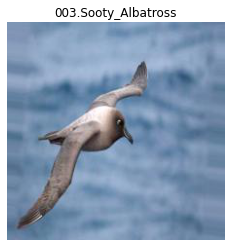

In [33]:
img = view_random_image(train_path,'003.Sooty_Albatross')

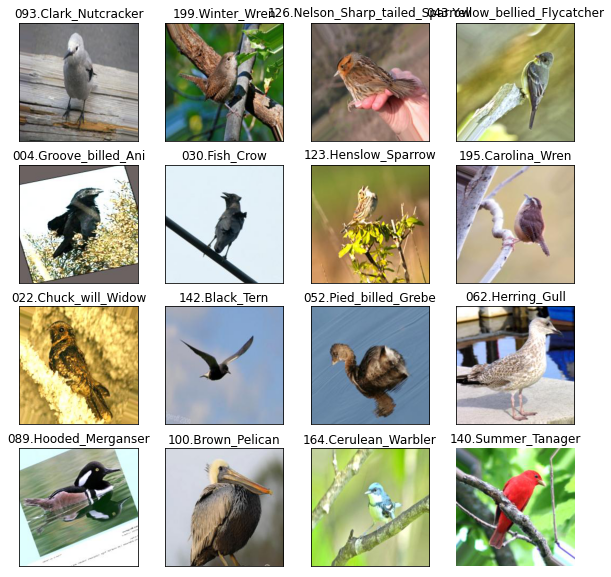

In [34]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

random_index = np.random.randint(0 , len(BirdClasses)-1 , 16)

for i, ax in enumerate(axes.flat):
    ax.imshow(view_random_image(train_path,BirdClasses[random_index[i]]))
    ax.set_title(BirdClasses[random_index[i]])

In [35]:
train_dir = "../input/bird200v1/train/"
test_dir = "../input/bird200v1/test/"
val_dir = "../input/bird200v1/val/"

In [36]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [37]:
train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory( train_dir , target_size=(224,224) , batch_size=32 , class_mode = "categorical" ,shuffle=True )

val_data = val_gen.flow_from_directory( val_dir , target_size=(224,224) , batch_size=32 , class_mode = "categorical" , shuffle=True )

test_data = test_gen.flow_from_directory( test_dir , target_size=(224,224) , batch_size=32 , class_mode = "categorical" ,shuffle=False )

Found 28000 images belonging to 200 classes.
Found 8000 images belonging to 200 classes.
Found 4000 images belonging to 200 classes.


In [38]:
# from keras.layers.rnn.cudnn_lstm import CuDNNLSTM
# from keras.layers.rnn.time_distributed import TimeDistributed
# from keras.layers.serialization import deserialize

In [39]:
mobilenet = MobileNetV2( include_top=False , weights="imagenet" , input_shape=(224,224,3))

mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [40]:
mobilenet.trainable=True

for layer in mobilenet.layers[:-20]:
  layer.trainable=False

In [41]:
Model = Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256,activation='relu'),
    BatchNormalization(),
    Dense(200,activation='softmax')
])

Model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               327936    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 200)               51400     
Total params: 2,643,464
Trainable params: 1,588,488
Non-trainable params: 1,054,976
____________________________________

In [42]:
Model.compile( optimizer="adam", loss="categorical_crossentropy" , metrics=["accuracy"] )

In [43]:
callbacks = [EarlyStopping(monitor='val_accuracy' , patience=5 , restore_best_weights=True)]

In [44]:
history = Model.fit(train_data,epochs=50 , batch_size=32 ,steps_per_epoch = len(train_data)
,callbacks=callbacks ,workers=10,use_multiprocessing=True, validation_data=val_data,validation_steps = len(val_data))

Epoch 1/50
875/875 [==============================] - 64s 69ms/step - loss: 2.1914 - accuracy: 0.4524 - val_loss: 6.5347 - val_accuracy: 0.1339
Epoch 2/50
875/875 [==============================] - 57s 64ms/step - loss: 1.0589 - accuracy: 0.6968 - val_loss: 4.0860 - val_accuracy: 0.3088
Epoch 3/50
875/875 [==============================] - 60s 67ms/step - loss: 0.6537 - accuracy: 0.8060 - val_loss: 2.6279 - val_accuracy: 0.4600
Epoch 4/50
875/875 [==============================] - 58s 66ms/step - loss: 0.4475 - accuracy: 0.8627 - val_loss: 3.7260 - val_accuracy: 0.3952
Epoch 5/50
875/875 [==============================] - 57s 64ms/step - loss: 0.3293 - accuracy: 0.8981 - val_loss: 2.0406 - val_accuracy: 0.5644
Epoch 6/50
875/875 [==============================] - 60s 67ms/step - loss: 0.2559 - accuracy: 0.9195 - val_loss: 2.2804 - val_accuracy: 0.5595
Epoch 7/50
875/875 [==============================] - 59s 66ms/step - loss: 0.2412 - accuracy: 0.9227 - val_loss: 2.1896 - val_accuracy:

In [45]:
results = Model.evaluate(test_data, verbose=0)


print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.42278
Test Accuracy: 74.37%


In [46]:
print(len(val_data))

250


In [47]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()
 #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()
  plt.show()
  plt.tight_layout()

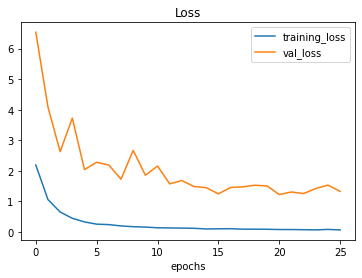

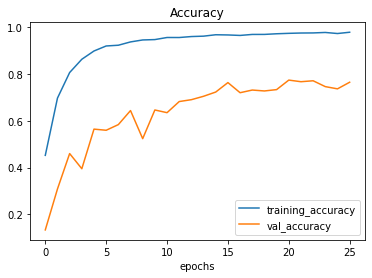

<Figure size 432x288 with 0 Axes>

In [48]:
plot_curves(history)

In [49]:
pred = Model.predict(test_data)
pred = np.argmax(pred,axis=1)

True Label: 004.Groove_billed_Ani
Predicted Label: 004.Groove_billed_Ani


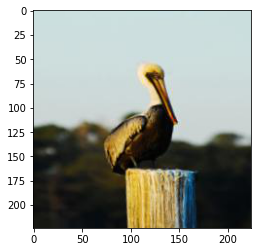

In [50]:
index =62

img , label = test_data[index]
label = test_data.labels[index]
print(f"True Label: {BirdClasses[label]}")
print(f"Predicted Label: {BirdClasses[pred[index]]}")  
plt.imshow(img[0])
plt.show()

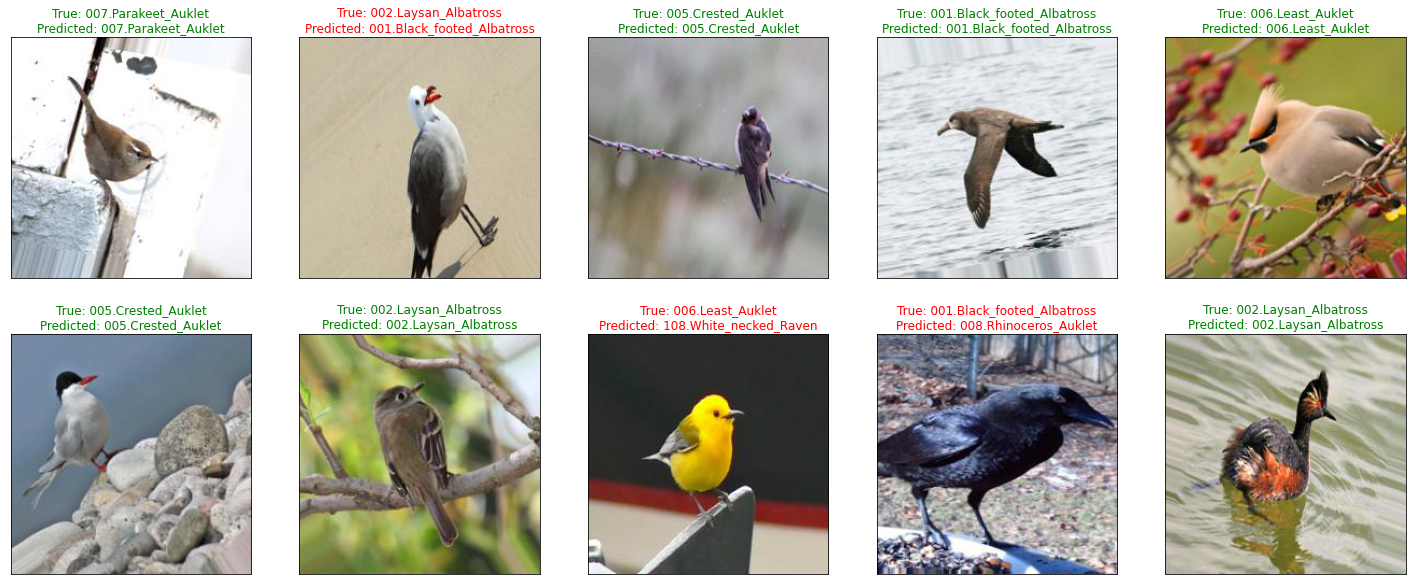

<Figure size 432x288 with 0 Axes>

In [51]:
# Display 10 random pictures from the dataset with their labels

random_index = np.random.randint(0, len(test_data) - 1, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    randImg , randLabel = test_data[random_index[i]]
    randLabel = test_data.labels[random_index[i]]
    ax.imshow(randImg[0])
    if BirdClasses[randLabel] == BirdClasses[pred[random_index[i]]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {BirdClasses[randLabel]}\nPredicted: {BirdClasses[pred[random_index[i]]]}", color=color)
plt.show()
plt.tight_layout()

In [52]:
def load_and_prep_image(filename, img_shape = 224):
  img = tf.io.read_file(filename) #read image
  img = tf.image.decode_image(img) # decode the image to a tensor
  img = tf.image.resize(img, size = [img_shape, img_shape]) # resize the image
  img = img/255. # rescale the image
  return img

In [53]:
def pred_and_plot(filename, class_names):

  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = Model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[pred.argmax()]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

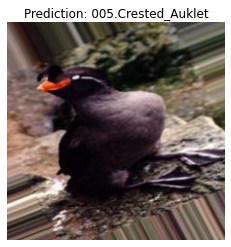

In [54]:
pred_and_plot("../input/bird200v1/test/005.Crested_Auklet/005.Crested_Aukleti_10_6862.jpg", BirdClasses)

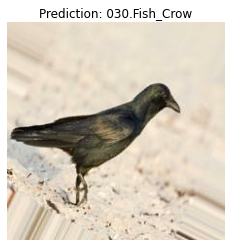

In [55]:
pred_and_plot("../input/bird200v1/test/030.Fish_Crow/030.Fish_Crow_11_3002.jpg", BirdClasses)


In [56]:
Model.save("BirdSpecies.h5")